## Pseudo-elastic Equation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft as fft
%matplotlib inline

# Make background for figures white
plt.rcParams['figure.facecolor'] = 'white'

In [3]:
def plot_fn_snapshot(fn, fig=None, axs=None, **kwargs):
    if fig is None and axs is None:
        fig, axs = plt.subplots(1, 1)
        im = axs.imshow(fn, **kwargs)
        return fig, axs, im
    
    im = axs.imshow(fn, **kwargs)
    return fig, axs, im

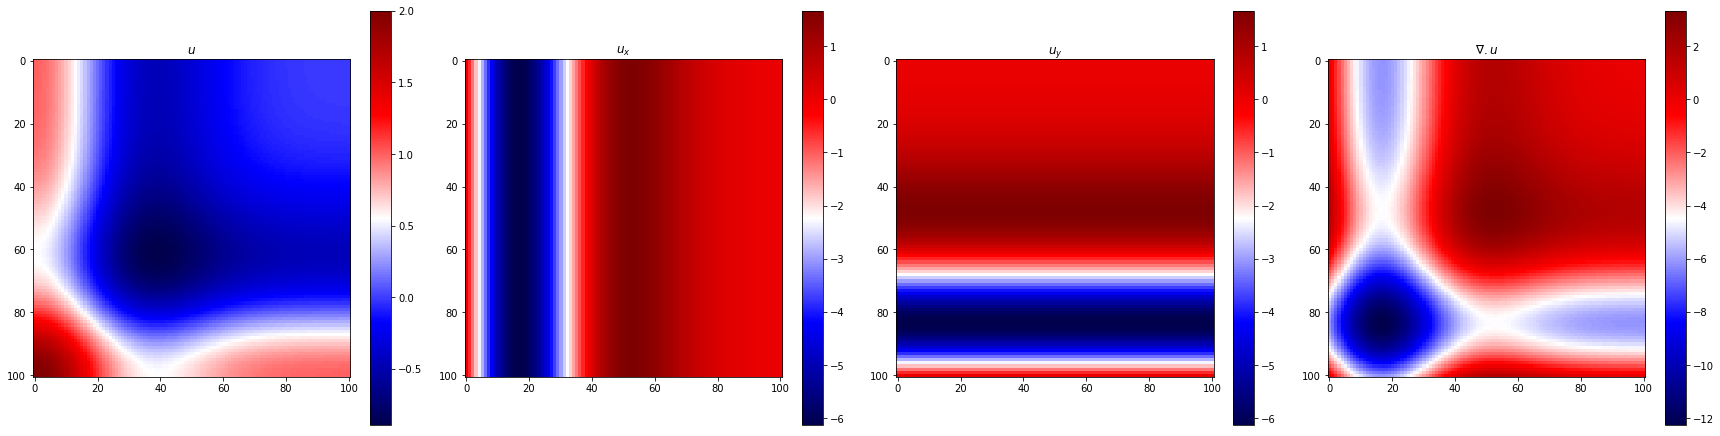

In [116]:
size = (101, 101)
u_initial = np.zeros(size)
u_dx = np.zeros(size)
u_dy = np.zeros(size)
# Set initial condition velocity
f = 1   # Wavelet frequency(Hz(?))
for i in range(size[0]):
    y = 1 - i / (size[0] - 1)
    for j in range(size[1]):
        x = j / (size[1] - 1)
#         Simple sine wave (x)
#         u_initial[i, j] = np.sin(2 * np.pi * x)
#         u_dx[i, j] = 2 * np.pi * np.cos(2 * np.pi * x)
#         u_dy[i, j] = 0

#         Ricker wavelet (x)
        u_initial[i, j] = (
            (1 - 2*np.pi**2*f**2*x**2)*np.exp(-1 * np.pi**2 * f**2 * x**2) +
            (1 - 2*np.pi**2*f**2*y**2)*np.exp(-1 * np.pi**2 * f**2 * y**2)
        )
        u_dy[i, j] = (
                      (np.exp(-1 * np.pi**2 * f**2 * y**2)*(-2*y*np.pi**2 * f**2)) * (1 - 2*np.pi**2*f**2*y**2) + 
                      (-2 * np.pi**2 * f**2 * 2 * y) * np.exp(-1 * np.pi**2 * f**2 * y**2)
                     )
        u_dx[i, j] = (
                      (np.exp(-1 * np.pi**2 * f**2 * x**2)*(-2*x*np.pi**2 * f**2)) * (1 - 2*np.pi**2*f**2*x**2) + 
                      (-2 * np.pi**2 * f**2 * 2 * x) * np.exp(-1 * np.pi**2 * f**2 * x**2)
                     )
#         Simple polynomial
#         u_initial[i, j] = 2 * (x-0.5)**2 - 9 * y
#         u_dx[i, j] = 4 * (x-0.5)
#         u_dy[i, j] = -9

fig, axs = plt.subplots(1, 4, figsize=(24, 6))
_, _, im0 = plot_fn_snapshot(u_initial, axs=axs[0], cmap='seismic')
_, _, im1 = plot_fn_snapshot(u_dx, axs=axs[1], cmap='seismic')
_, _, im2 = plot_fn_snapshot(u_dy, axs=axs[2], cmap='seismic')
_, _, im3 = plot_fn_snapshot((u_dx + u_dy), axs=axs[3], cmap='seismic')
fig.colorbar(im0, ax=axs[0])
fig.colorbar(im1, ax=axs[1])
fig.colorbar(im2, ax=axs[2])
fig.colorbar(im3, ax=axs[3])
axs[0].set_title(r"$u$")
axs[1].set_title(r"$u_x$")
axs[2].set_title(r"$u_y$")
axs[3].set_title(r"$\nabla . u$")
fig.tight_layout(pad=0.5)

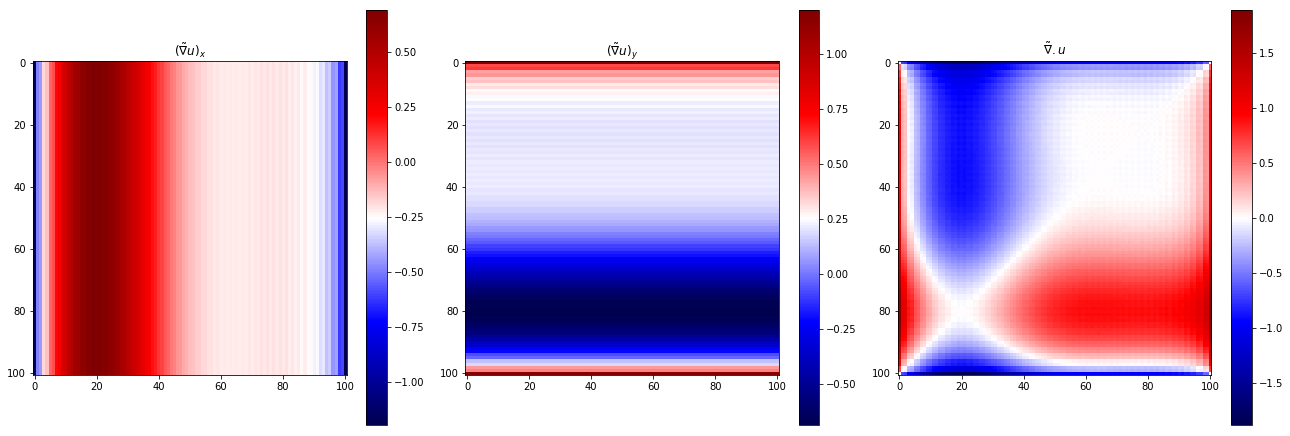

In [117]:
def normalized_gradient(f, dim=2, eps=1e-6):
    size = f.data.shape
    f_x, f_y = fft.fftfreq(size[1]), fft.fftfreq(size[0])
    f_fft = fft.fftn(f)
#     norm_grad = np.zeros((f.shape[0], f.shape[1], dim), dtype=complex)
    ddx = np.zeros(f.shape, dtype=complex)
    ddy = np.zeros(f.shape, dtype=complex)
    for i in range(f_fft.shape[0]):
        for j in range(f_fft.shape[1]):
            k_x, k_y = f_x[j], f_y[i]
            ddx[i, j] = -(1j * k_x) * f_fft[i, j]  / np.sqrt(k_x**2 + k_y**2 + eps)
            ddy[i, j] = -(1j * k_y) * f_fft[i, j]  / np.sqrt(k_x**2 + k_y**2 + eps)
    ddx = fft.ifftn(ddx)
    ddy = fft.ifftn(ddy)
    return ddx, ddy

def normalized_div(f, dim=2, eps=1e-6):
    ddx, ddy = normalized_gradient(f, dim=dim, eps=eps)
    return -(ddx + ddy)

# fig, axs = plt.subplots(1, 2)
ddx, ddy = normalized_gradient(u_initial)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

fig, axs[0], im0 = plot_fn_snapshot(np.real(ddx), fig=fig, axs=axs[0], cmap='seismic')
cbar0 = fig.colorbar(im0, ax=axs[0])
axs[0].set_title(r"$(\tilde{\nabla}u)_x$")

fig, axs[1], im1 = plot_fn_snapshot(np.real(ddy), fig=fig, axs=axs[1], cmap='seismic')
cbar1 = fig.colorbar(im1, ax=axs[1])
axs[1].set_title(r"$(\tilde{\nabla}u)_y$")
n_div = normalized_div(u_initial)
fig, axs[2], im2 = plot_fn_snapshot(np.real(n_div), fig=fig, axs=axs[2], cmap='seismic')
cbar2 = fig.colorbar(im2, ax=axs[2])
axs[2].set_title(r"$\tilde{\nabla} . u$")
fig.tight_layout(pad=0.5)

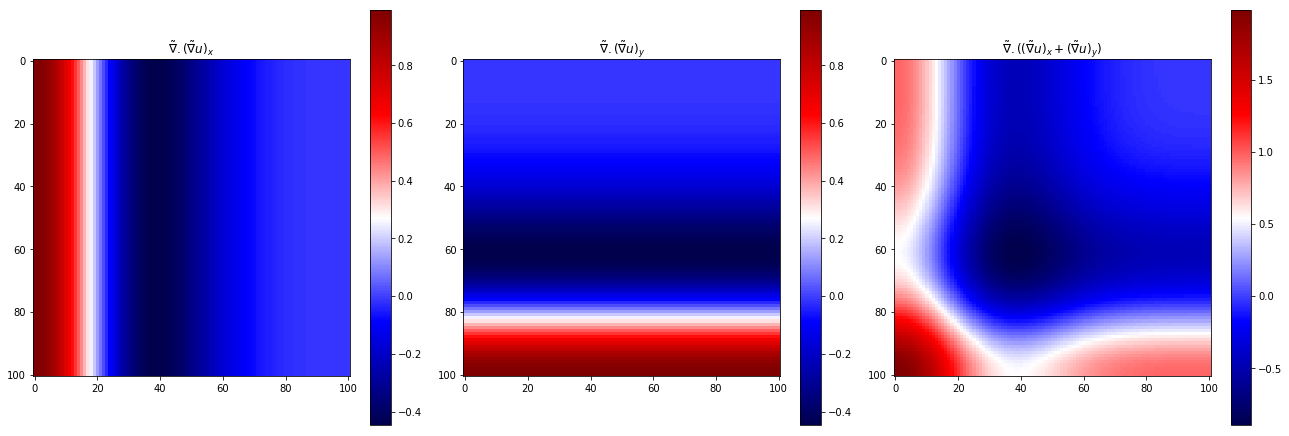

In [118]:
div_ddx = normalized_div(ddx)
div_ddy = normalized_div(ddy)
div_grad_u = div_ddx + div_ddy
# plt.imshow(np.real(div_grad_u), cmap='seismic')
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
_, _, im0 = plot_fn_snapshot(np.real(div_ddx), fig=fig, axs=axs[0], cmap='seismic')
_, _, im1 = plot_fn_snapshot(np.real(div_ddy), fig=fig, axs=axs[1], cmap='seismic')
_, _, im2 = plot_fn_snapshot(np.real(div_grad_u), fig=fig, axs=axs[2], cmap='seismic')
fig.colorbar(im0, ax=axs[0])
fig.colorbar(im1, ax=axs[1])
fig.colorbar(im2, ax=axs[2])
axs[0].set_title(r"$\tilde{\nabla} . (\tilde{\nabla} u)_x$")
axs[1].set_title(r"$\tilde{\nabla} . (\tilde{\nabla} u)_y$")
axs[2].set_title(r"$\tilde{\nabla} . ((\tilde{\nabla} u)_x + (\tilde{\nabla} u)_y)$")
fig.tight_layout(pad=0.5)

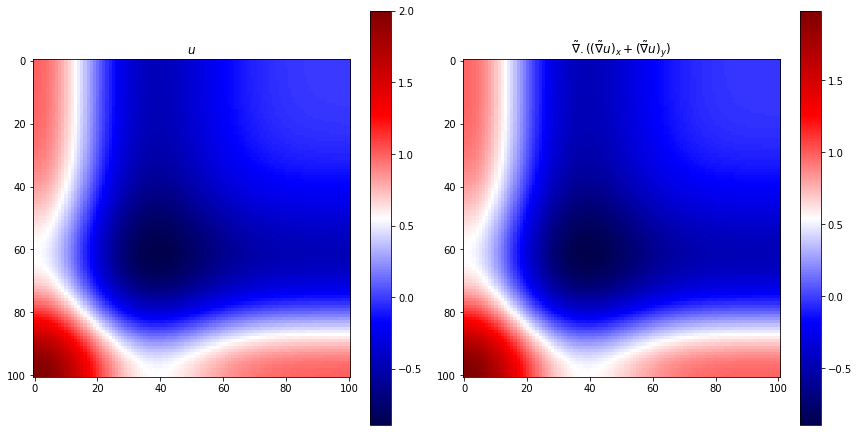

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
_, _, im0 = plot_fn_snapshot(np.real(u_initial), fig=fig, axs=axs[0], cmap='seismic')
_, _, im1 = plot_fn_snapshot(np.real(div_grad_u), fig=fig, axs=axs[1], cmap='seismic')
axs[0].set_title("$u$")
axs[1].set_title(r"$\tilde{\nabla} . ((\tilde{\nabla} u)_x + (\tilde{\nabla} u)_y)$")
fig.colorbar(im0, ax=axs[0])
fig.colorbar(im1, ax=axs[1])
fig.tight_layout(pad=0.5)

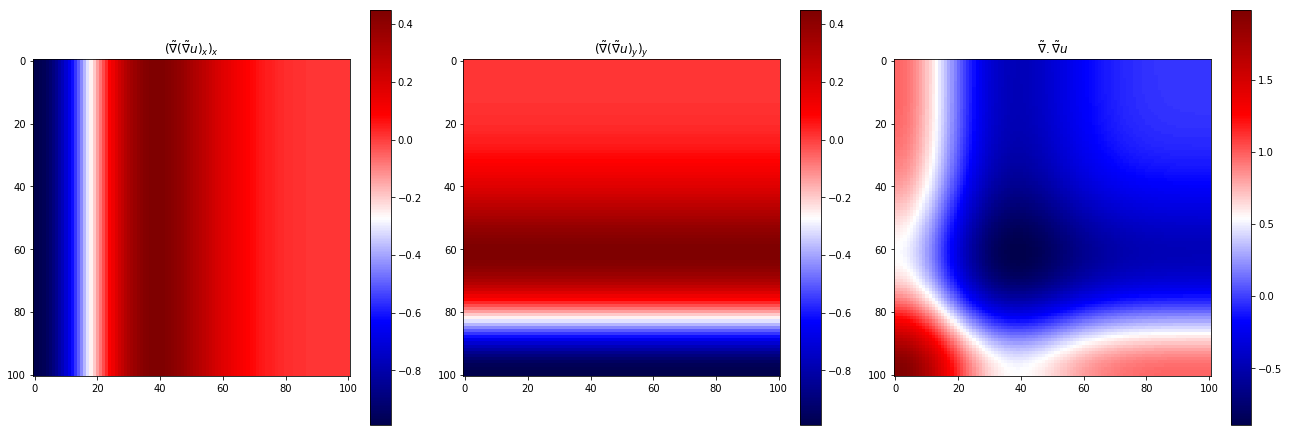

In [119]:
ddx_ddx, _ = normalized_gradient(ddx)
_, ddy_ddy = normalized_gradient(ddy)
laplace_u = -(ddx_ddx + ddy_ddy)
# plt.imshow(np.real(div_grad_u), cmap='seismic')
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
_, _, im0 = plot_fn_snapshot(np.real(ddx_ddx), fig=fig, axs=axs[0], cmap='seismic')
_, _, im1 = plot_fn_snapshot(np.real(ddy_ddy), fig=fig, axs=axs[1], cmap='seismic')
_, _, im2 = plot_fn_snapshot(np.real(laplace_u), fig=fig, axs=axs[2], cmap='seismic')
fig.colorbar(im0, ax=axs[0])
fig.colorbar(im1, ax=axs[1])
fig.colorbar(im2, ax=axs[2])
axs[0].set_title(r"$(\tilde{\nabla} (\tilde{\nabla} u)_x)_x$")
axs[1].set_title(r"$(\tilde{\nabla} (\tilde{\nabla} u)_y)_y$")
axs[2].set_title(r"$\tilde{\nabla} . \tilde{\nabla} u$")
fig.tight_layout(pad=0.5)

-0.0018656659930014197
-0.8956230494195647 -0.892520033486792


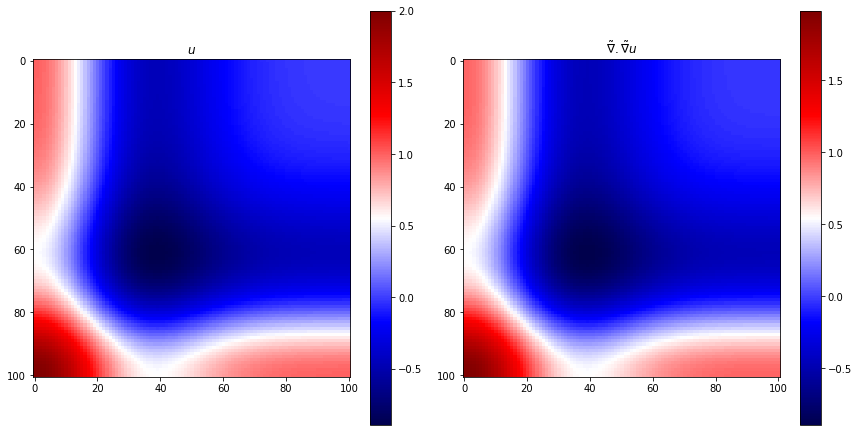

In [128]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
_, _, im0 = plot_fn_snapshot(np.real(u_initial), fig=fig, axs=axs[0], cmap='seismic')
_, _, im1 = plot_fn_snapshot(np.real(laplace_u), fig=fig, axs=axs[1], cmap='seismic')
axs[0].set_title("$u$")
axs[1].set_title(r"$\tilde{\nabla} . \tilde{\nabla} u$")
fig.colorbar(im0, ax=axs[0])
fig.colorbar(im1, ax=axs[1])
fig.tight_layout(pad=0.5)

print(np.max(np.real((laplace_u - u_initial))))
print(np.min(np.real(laplace_u)), np.min(u_initial))

## Equation(s)

$$P = \tilde{\nabla} \mathbf{u}$$

$$\partial_{t}^2 P = \tilde{\nabla} \cdot \mathbf{E}\tilde{\nabla}P + \tilde{\nabla} \frac{1}{\rho}(\mathbf{f} + \nabla \cdot \mathbf{m})$$

$$\frac{P_{t+1} + P_{t-1} - 2P_{t}}{dt^2} = \tilde{\nabla} \cdot \mathbf{E}\tilde{\nabla}P_{t} + \tilde{\nabla} s$$
$$\implies P_{t+1} = dt^2\left(\tilde{\nabla} \cdot \mathbf{E}\tilde{\nabla}P^{t} + \tilde{\nabla} s \right) + 2P_{t} - P_{t-1} $$


Consider $\mathbf{E}\tilde{\nabla}P$
$$
\mathbf{E}\tilde{\nabla}P = \begin{bmatrix}
\partial_{x} (\lambda + 2\mu) \partial_{x} + \partial_{y} \mu \partial_{y} &
\partial_{x} \lambda \partial_{y} + \partial_y \mu \partial_{x}\\
\partial_{y} \lambda \partial_{x} + \partial_{x} \mu \partial_{y}  &
\partial_{x}\mu\partial_{x} + \partial_{y} (\lambda + 2 \mu) \partial_{y}
\end{bmatrix}
.
\begin{bmatrix}
(\tilde{\nabla}P)_{x}\\
(\tilde{\nabla}P)_{y}
\end{bmatrix}
$$

Assuming constant $\lambda, \mu$, we have

$$
\mathbf{E}\tilde{\nabla}P = \begin{bmatrix}
(\lambda + 2\mu) \partial^{2}_{x} + \mu \partial^{2}_{y} &
(\lambda + \mu) \partial_{x} \partial_{y}\\
(\lambda + \mu) \partial_{x} \partial_{y} &
(\lambda + 2\mu) \partial^{2}_{y} + \mu \partial^{2}_{x}
\end{bmatrix}
.
\begin{bmatrix}
(\tilde{\nabla}P)_{x}\\
(\tilde{\nabla}P)_{y}
\end{bmatrix}
$$
$$
= \begin{bmatrix}
((\lambda + 2\mu) \partial^{2}_{x} + \mu \partial^{2}_{y}) (\tilde{\nabla}P)_{x} \;+\;((\lambda + \mu) \partial_{x} \partial_{y}) ((\tilde{\nabla}P)_{y})\\
((\lambda + \mu) \partial_{x} \partial_{y})(\tilde{\nabla}P)_{x} \;+\; ((\lambda + 2\mu) \partial^{2}_{y} + \mu \partial^{2}_{x}) ((\tilde{\nabla}P)_y)
\end{bmatrix}
$$

In [132]:
def s(t, f=1):
    return (1 - 2*np.pi**2*f**2*t**2)*np.exp(-1 * np.pi**2 * f**2 * t**2)

# u_initial = np.ones(size)
# P_x, P_y = normalized_gradient(u_initial)
P_x, P_y = np.zeros(size, dtype=complex), np.zeros(size, dtype=complex)
P_x_next, P_y_next = np.array(P_x), np.array(P_y)
P_x_prev, P_y_prev = np.array(P_x), np.array(P_y)
src_i = size[0]//2
src_j = size[1]//2
dt = 0.04
tn = 81 * dt
t0 = 0
t = t0
lam = 1
mu = 0
dx = 0.1
frames = []
it = 0
frame_interval = 16

while t < tn:
    P_xx, P_xy = normalized_gradient(P_x)
    P_yx, P_yy = normalized_gradient(P_y)
    grad_Px = P_xx + P_yx
    grad_Py = P_xy + P_yy
    dx_grad_Px = np.array(grad_Px)
    dx2_grad_Px = np.array(grad_Px)
    dy_grad_Px = np.array(grad_Px)
    dy2_grad_Px = np.array(grad_Px)
    dxdy_grad_Px = np.array(grad_Px)
    
    dx_grad_Py = np.array(grad_Py)
    dx2_grad_Py = np.array(grad_Py)
    dy_grad_Py = np.array(grad_Py)
    dy2_grad_Py = np.array(grad_Py)
    dxdy_grad_Py = np.array(grad_Py)
    
    E_gradP_y = np.array(grad_Py)
    E_gradP_x = np.array(grad_Py)
    EgPx_ddx = np.array(grad_Py)
    EgPy_ddy = np.array(grad_Py)
    # Assume constant lambda and mu for now
#     for i in range(1, size[0]-1):
#         for j in range(1, size[1]-1):
#             # Gather derivatives (FD)
            
#             dx_grad_Px[i, j] = (grad_Px[i, j+1] - grad_Px[i, j-1]) / (2*dx)
#             dx2_grad_Px[i, j] = (grad_Px[i, j+1] + grad_Px[i, j-1] - 2 * grad_Px[i, j]) / (dx**2)
#             dy_grad_Px[i, j] = (grad_Px[i-1, j] - grad_Px[i+1, j]) / (2*dx)
#             dy2_grad_Px[i, j] = (grad_Px[i-1, j] + grad_Px[i+1, j] - 2*grad_Px[i, j]) / (2*dx)
#             dxdy_grad_Px[i, j] = (dx_grad_Px[i-1, j] - dx_grad_Px[i+1, j]) / (2*dx)
#             # More derivatives (FD)
#             dx_grad_Py[i, j] = (grad_Py[i, j+1] - grad_Py[i, j-1]) / (2*dx)
#             dx2_grad_Py[i, j] = (grad_Py[i, j+1] + grad_Py[i, j-1] - 2 * grad_Py[i, j]) / (dx**2)
#             dy_grad_Py[i, j] = (grad_Py[i-1, j] - grad_Py[i+1, j]) / (2*dx)
#             dy2_grad_Py[i, j] = (grad_Py[i-1, j] + grad_Py[i+1, j] - 2 * grad_Py[i, j]) / (dx**2)
#             dxdy_grad_Py[i, j] = (dy_grad_Py[i, j+1] - dy_grad_Py[i, j-1]) / (2 * dx)
            
#     dx_grad_Px[1:-1] = (grad_Px[1:-1, 2:] - grad_Px[1:-1, :-2]) / (2*dx)
    dx2_grad_Px[1:-1, 1:-1] = (grad_Px[1:-1, 2:] + grad_Px[1:-1, :-2] - 2*grad_Px[1:-1, 1:-1]) / (dx**2)
    dy2_grad_Px[1:-1, 1:-1] = (grad_Px[2:, 1:-1] + grad_Px[:-2, 1:-1] - 2*grad_Px[1:-1, 1:-1]) / (dx**2)
    
    dx2_grad_Py[1:-1, 1:-1] = (grad_Py[1:-1, 2:] + grad_Py[1:-1, :-2] - 2*grad_Py[1:-1, 1:-1]) / (dx**2)
    dy2_grad_Py[1:-1, 1:-1] = (grad_Py[2:, 1:-1] + grad_Py[:-2, 1:-1] - 2*grad_Py[1:-1, 1:-1]) / (dx**2)
#     print(dy2_grad_Py.shape, dx2_grad_Py.shape)
    # Separate out mat-mult
    E_gradP_x[1:-1, 1:-1] = (lam + 2*mu)*dx2_grad_Px[1:-1, 1:-1] + mu * dy2_grad_Px[1:-1, 1:-1]# + (lam + mu)*dxdy_grad_Py[1:-1, 1:-1]
    E_gradP_y[1:-1, 1:-1] = (lam + 2*mu)*dy2_grad_Py[1:-1, 1:-1] + mu * dx2_grad_Py[1:-1, 1:-1]# + (lam + mu)*dxdy_grad_Px[1:-1, 1:-1]
    # Calculate div
    EgPx_ddx[1:-1, 1:-1], _ = normalized_gradient(E_gradP_x[1:-1, 1:-1])
    _, EgPy_ddy[1:-1, 1:-1] = normalized_gradient(E_gradP_y[1:-1, 1:-1])
    EgP_div[1:-1, 1:-1] = -(EgPx_ddx[1:-1, 1:-1] + EgPy_ddy[1:-1, 1:-1])
        
    P_x_next[1:-1, 1:-1] = dt**2 * (EgP_div[1:-1, 1:-1]) + 2 * P_x[1:-1, 1:-1] - P_x_prev[1:-1, 1:-1]
    P_y_next[1:-1, 1:-1] = dt**2 * (EgP_div[1:-1, 1:-1]) + 2 * P_y[1:-1, 1:-1] - P_y_prev[1:-1, 1:-1]
    P_x_next[src_i, src_j] += s(t)
    P_y_next[src_i, src_j] += s(t)
    
    P_x_prev[:] = P_x
    P_y_prev[:] = P_y
    P_x[:] = P_x_next
    P_y[:] = P_y_next
    if it % frame_interval == 0:
        frames.append((np.array(P_x), np.array(P_y)))
        print("Reached iteration #:{}".format(it))
    t += dt
    it += 1

print(len(frames))

Reached iteration #:0
Reached iteration #:16
Reached iteration #:32
Reached iteration #:48
Reached iteration #:64
Reached iteration #:80
6


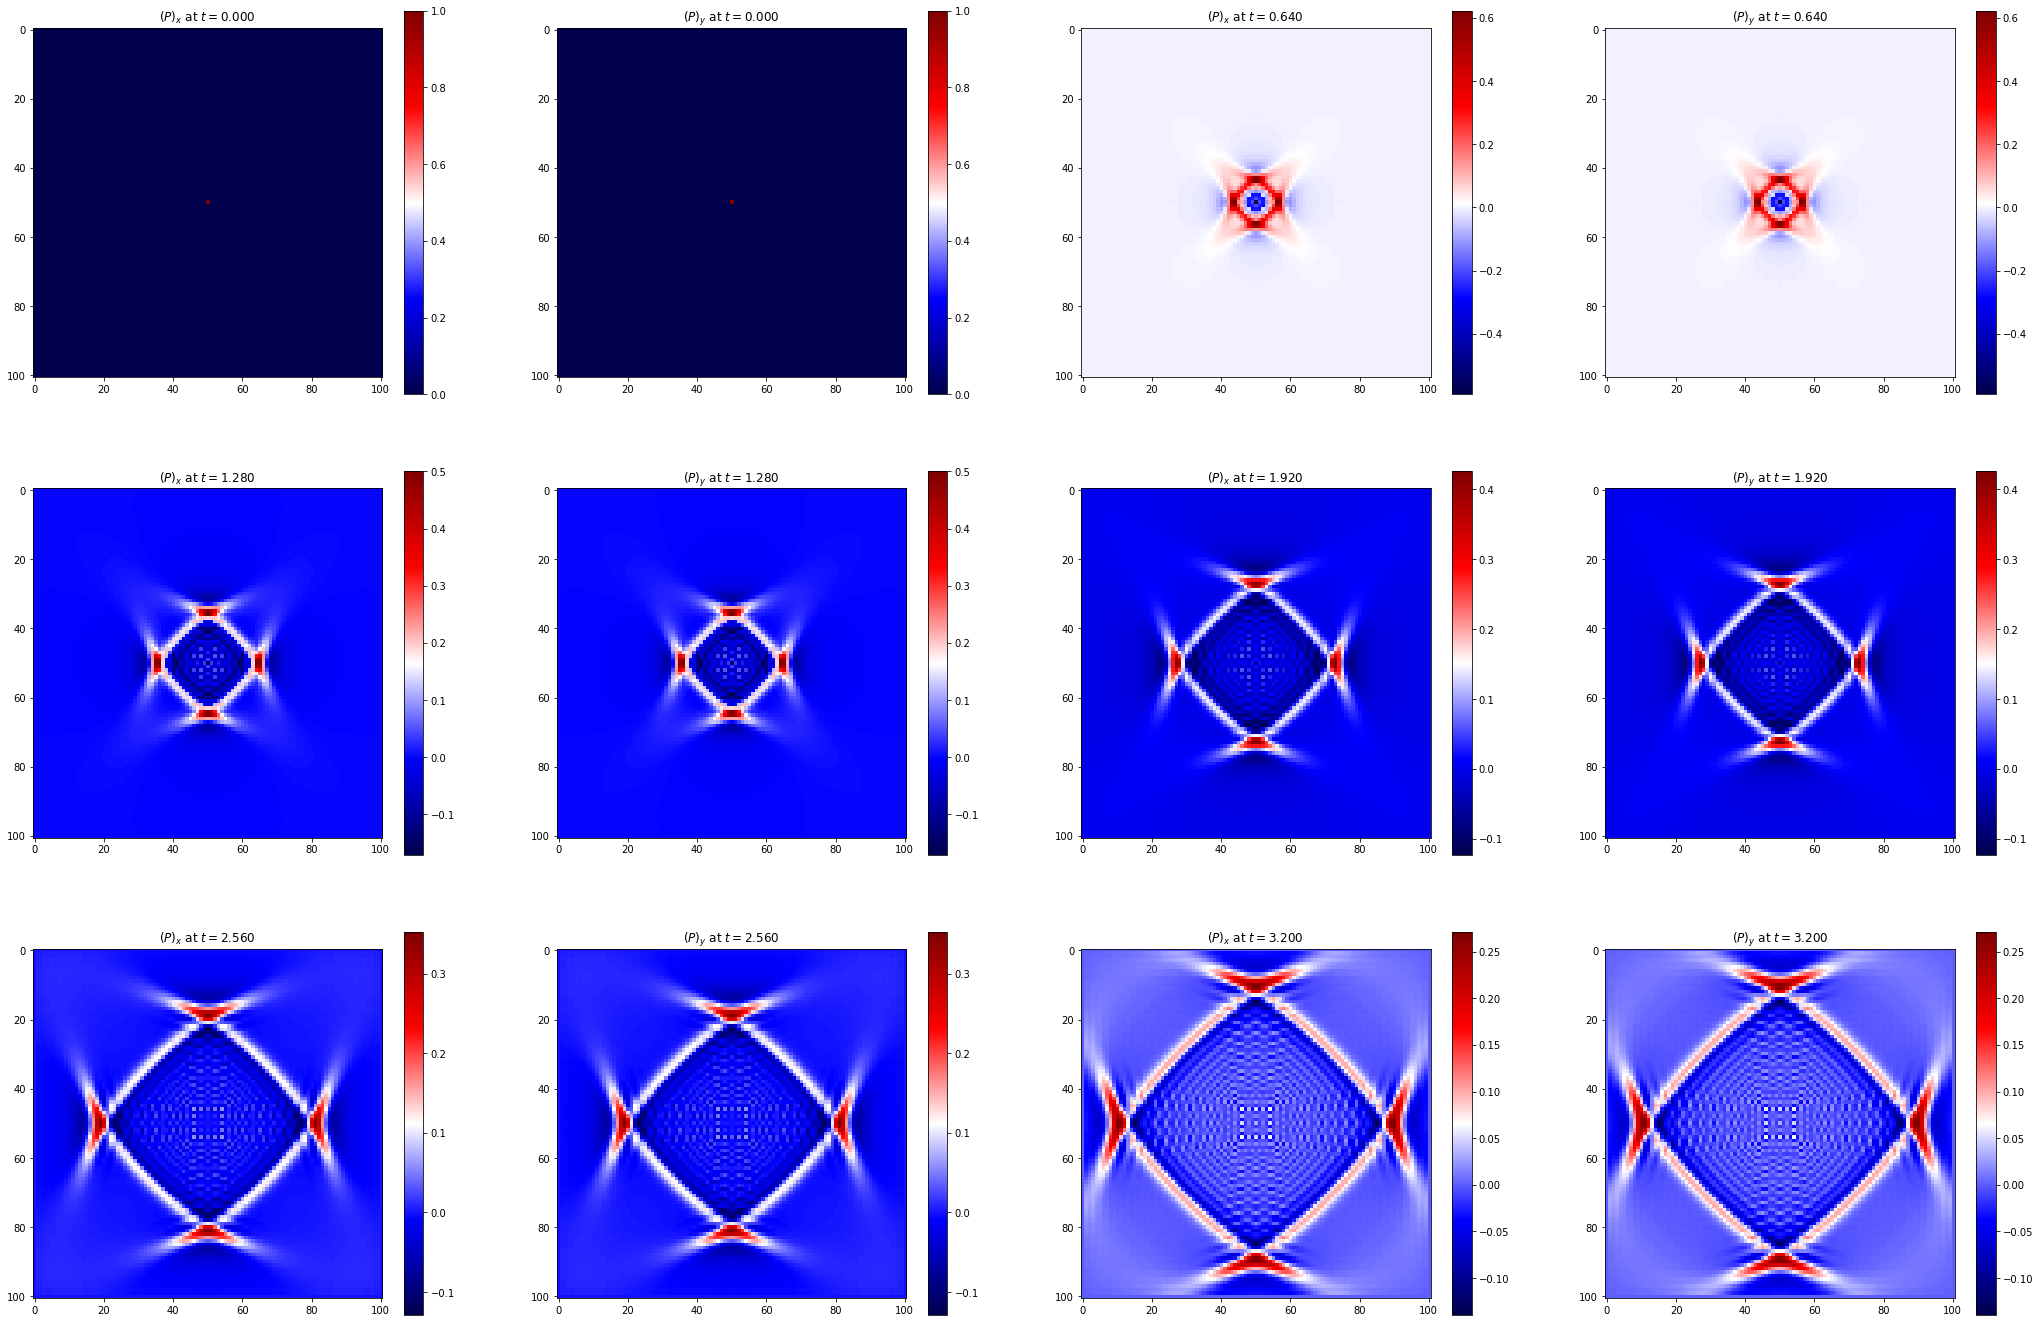

In [133]:
# print(len(frames))
rows = len(frames) // 2
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(12 * rows, 6 * cols))
for i in range(axs.shape[0]):
    # 2*i, 2*i+1
    _, _, im0 = plot_fn_snapshot(np.real(frames[2*i][0]), fig=fig, axs=axs[i][0], cmap='seismic')
    axs[i][0].set_title(r"$(P)_x$ at $t={:.3f}$".format(dt * 2 * i * frame_interval))
    fig.colorbar(im0, ax=axs[i][0])
    _, _, im1 = plot_fn_snapshot(np.real(frames[2*i][1]), fig=fig, axs=axs[i][1], cmap='seismic')
    axs[i][1].set_title(r"$(P)_y$ at $t={:.3f}$".format(dt * 2 * i * frame_interval))
    fig.colorbar(im1, ax=axs[i][1])
    
    _, _, im2 = plot_fn_snapshot(np.real(frames[2*i + 1][0]), fig=fig, axs=axs[i][2], cmap='seismic')
    axs[i][2].set_title(r"$(P)_x$ at $t={:.3f}$".format(dt * (2 * i + 1) * frame_interval))
    fig.colorbar(im2, ax=axs[i][2])
    _, _, im3 = plot_fn_snapshot(np.real(frames[2*i + 1][1]), fig=fig, axs=axs[i][3], cmap='seismic')
    axs[i][3].set_title(r"$(P)_y$ at $t={:.3f}$".format(dt * (2 * i + 1) * frame_interval))
    fig.colorbar(im3, ax=axs[i][3])

### Acoustic wave for comparison

$$
\frac{\partial^2}{\partial t^2} p = \lambda \nabla \cdot \nabla p + s
$$

In [99]:
def s(t, f=0.5):
    return (1 - 2*np.pi**2*f**2*t**2)*np.exp(-1 * np.pi**2 * f**2 * t**2)

v = np.ones(size)
p, p_old, p_new = np.zeros(size), np.zeros(size), np.zeros(size)
src_i = size[0]//2
src_j = size[1]//2
dt = 0.04
tn = 81 * dt
t0 = 0
t = t0
dt = 0.04
dx = 0.1
p[src_i, src_j] += s(0)
it = 0
frame_interval = 16
frames = []
while t < tn:
    t += dt
    p_new[1:-1, 1:-1] = dt**2/dx**2 * ((-4 * p[1:-1, 1:-1] + p[:-2, 1:-1] + p[2:, 1:-1] + p[1:-1, :-2] +p[1:-1, 2:]))
    p_new[1:-1, 1:-1] += 2*p[1:-1, 1:-1] - p_old[1:-1, 1:-1]
    p_new[src_i, src_j] += s(t)
    if it % frame_interval == 0:
        frames.append(np.array(p))
    p, p_old, p_new = p_new, p, p_old
    it += 1
print(len(frames))

6


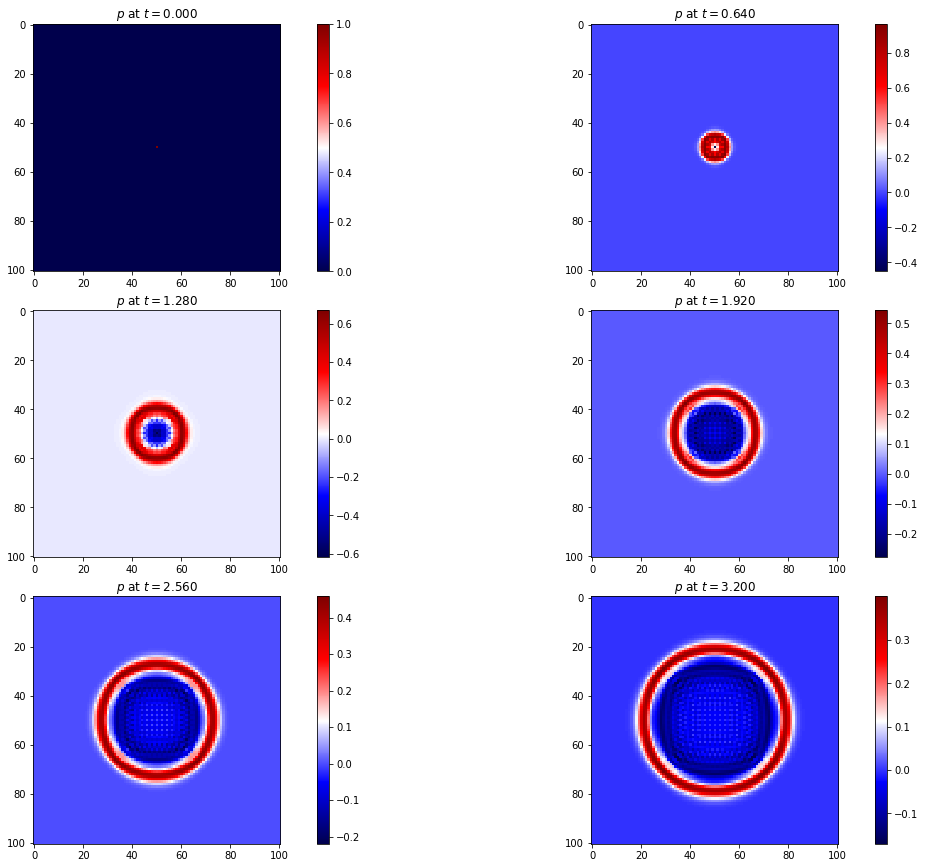

In [100]:
rows = len(frames) // 2
cols = 2
fig, axs = plt.subplots(rows, cols, figsize=(6 * rows, 6 * cols))
for i in range(axs.shape[0]):
    _, _, im0 = plot_fn_snapshot(np.real(frames[2*i]), fig=fig, axs=axs[i][0], cmap='seismic')
    axs[i][0].set_title(r"$p$ at $t={:.3f}$".format(dt * 2 * i * frame_interval))
    fig.colorbar(im0, ax=axs[i][0])
    
    _, _, im2 = plot_fn_snapshot(np.real(frames[2*i + 1]), fig=fig, axs=axs[i][1], cmap='seismic')
    axs[i][1].set_title((r"$p$ at $t={:.3f}$".format(dt * (2 * i + 1) * frame_interval)))
    fig.colorbar(im2, ax=axs[i][1])
fig.tight_layout(pad=0.5)